# Exploring Data with Fema

### Introduction

In this lesson, we'll look at FEMA claims data gathered for the [Washington Post's article on Houston Flooding](https://www.washingtonpost.com/graphics/2017/investigations/harvey-urban-planning/) which they made available [here](https://github.com/wpinvestigative/fema_claims).  Let's load up the data and see what we have.

### Loading the Data

In [ ]:
import pandas as pd 
url = "https://raw.githubusercontent.com/jigsawlabs-student/exploring-pandas/master/formatted_claims_all.txt"
df = pd.read_csv(url, sep='\t')

Use head to take a look at the first five rows of data.

In [26]:
first_five = df.head(5)
first_five

# 	state	county	community	total_loss	closed_loss	open_loss	cwop_loss	total_pay
# 0	ALABAMA	AUTAUGA COUNTY	AUTAUGA COUNTY *	33.0	23.0	2.0	8.0	518669.96
# 1	ALABAMA	AUTAUGA COUNTY	AUTAUGAVILLE, TOWN OF	1.0	0.0	0.0	1.0	0.00
# 2	ALABAMA	AUTAUGA COUNTY	MILLBROOK, CITY OF	9.0	6.0	0.0	3.0	74633.64
# 3	ALABAMA	AUTAUGA COUNTY	MONTGOMERY, CITY OF	295.0	195.0	6.0	94.0	4113018.78
# 4	ALABAMA	AUTAUGA COUNTY	PRATTVILLE, CITY OF	45.0	35.0	3.0	7.0	700387.26

,state,county,community,total_loss,closed_loss,open_loss,cwop_loss,total_pay
0,ALABAMA,AUTAUGA COUNTY,AUTAUGA COUNTY *,33.0,23.0,2.0,8.0,518669.96
1,ALABAMA,AUTAUGA COUNTY,"AUTAUGAVILLE, TOWN OF",1.0,0.0,0.0,1.0,0.00
2,ALABAMA,AUTAUGA COUNTY,"MILLBROOK, CITY OF",9.0,6.0,0.0,3.0,74633.64
3,ALABAMA,AUTAUGA COUNTY,"MONTGOMERY, CITY OF",295.0,195.0,6.0,94.0,4113018.78
4,ALABAMA,AUTAUGA COUNTY,"PRATTVILLE, CITY OF",45.0,35.0,3.0,7.0,700387.26


Let's try to get a sense of what these loss and pay columns mean.  A quick Google search takes us to [the following data dictionary](https://www.fema.gov/data-definitions-claim-information-state-and-policy-information-state).

<img src="./data-dictionary-fema.png" width="50%">

### Reducing our Data

So it looks like the data in the total loss column is a sum of the other loss columns.  Let's confirm that.

> Find a dataframe (or a series) selecting all of the rows where they are not equal.

In [13]:
loss_cols = ['closed_loss', 'open_loss', 'cwop_loss']
df_loss = df[loss_cols]

df_loss[~(df_loss.sum(axis = 1) == df['total_loss'])].shape
# (56, 3)

(56, 3)

Now let's look at the entire dataset to see what portion of these columns are not equal.

In [14]:
df.shape

(15533, 8)

It looks like the total loss column is, as the kids say, [extra](https://www.urbandictionary.com/define.php?term=extra). Let's get rid of it.

In [15]:
reduced_df = df.drop('total_loss', axis = 1)
reduced_df.columns
# Index(['state', 'county', 'community', 'closed_loss', 'open_loss', 'cwop_loss',
#        'total_pay'],

Index(['state', 'county', 'community', 'closed_loss', 'open_loss', 'cwop_loss',
       'total_pay'],
      dtype='object')

Now let's take a look at the missing data.  Let's get a count of the missing values across the columns.

In [17]:
reduced_df.isna().sum()

# state           0
# county          0
# community       0
# closed_loss    56
# open_loss      56
# cwop_loss      56
# total_pay      56

state           0
county          0
community       0
closed_loss    56
open_loss      56
cwop_loss      56
total_pay      56
dtype: int64

It looks like when one column is missing, the rest are also missing.  Let's confirm this.  Select all of the rows where just `closed_loss` is `na`.

In [19]:
closed_loss_na = reduced_df[reduced_df['closed_loss'].isna()]

closed_loss_na.shape
# (56, 7)

(56, 7)

Let's take a look.

In [20]:
closed_loss_na[:3]

,state,county,community,closed_loss,open_loss,cwop_loss,total_pay
242,ALASKA,--------------------------------,--------------------------------,NaN,NaN,NaN,NaN
264,AMERICAN SAMOA,--------------------------------,--------------------------------,NaN,NaN,NaN,NaN
266,ARIZONA,--------------------------------,--------------------------------,NaN,NaN,NaN,NaN


Ok, if we look across all of the rows, we can see that each row is completely blank.  It appears that this may be simply a list of the states and territories.

In [22]:
closed_loss_na.state[:5]

242            ALASKA
264    AMERICAN SAMOA
266           ARIZONA
355          ARKANSAS
624        CALIFORNIA
Name: state, dtype: object

Ok, it seems safe to drop each of these rows.  Remove the rows that have missing data and assign the result to the variable `reduced_no_missing`.

In [25]:
reduced_no_missing = reduced_df.dropna()

reduced_no_missing.shape

# (15477, 7)

(15477, 7)

### Exploring Data

Now that we've cleaned up some of our data, let's do a check to see that our data is of the correct type, before we attempt to perform any analysis.

In [27]:
reduced_no_missing.dtypes

# state           object
# county          object
# community       object
# closed_loss    float64
# open_loss      float64
# cwop_loss      float64
# total_pay      float64
# dtype: object


state           object
county          object
community       object
closed_loss    float64
open_loss      float64
cwop_loss      float64
total_pay      float64
dtype: object

Ok, looks good.

Now let's get a sense of some of our data.  We have data from all fifty states, but let's just focus on Texas for now.

In [30]:
texas_df = reduced_no_missing[reduced_no_missing['state'] == 'TEXAS']

In [31]:
texas_df.shape

(896, 7)

This seems a little more manageable.

Ok, let's try creating a histogram of all of our numeric columns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f28c790>,
      dtype=object)

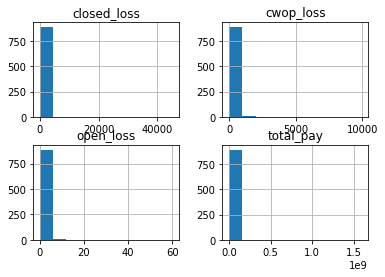

In [33]:
texas_df.hist()

> Answer <img src="./hist-tx-fema.png" width="50%">

Hmm, not very useful.  It looks like outliers are expanding the range of our data.  Let's choose just the `closed_loss` column, which remember represents a count of the losses that have been paid.  Set an range on the x values at 10000, with 500 bins.  Label. the x and y axes, and assign a title.

[Text(0, 0.5, 'count'), Text(0.5, 0, 'no. claims')]

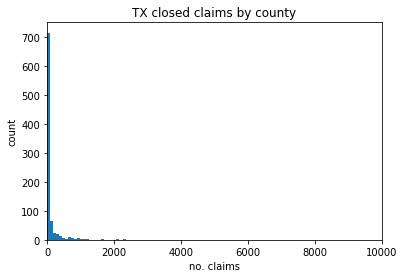

In [47]:
ax = texas_df['closed_loss'].plot(kind = 'hist', xlim = [0, 10000], 
                                  bins = 500,
                                  title = 'TX closed claims by county')
ax.set(xlabel = 'no. claims', ylabel = 'count')

> Answer: <img src="./tx-closed-claims-style.png" width="50%">

Ok, perhaps a little better, but not great.  Let's use `describe` to see if it can help us set a range for our data.

In [53]:
C.describe()

# count      896.000000
# mean       241.588170
# std       1922.330777
# min          0.000000
# 25%          2.000000
# 50%         10.500000
# 75%         59.250000
# max      45059.000000

count      896.000000
mean       241.588170
std       1922.330777
min          0.000000
25%          2.000000
50%         10.500000
75%         59.250000
max      45059.000000
Name: closed_loss, dtype: float64

Ok, so it looks like most of our data is between 2 and 59 claims, and there's a max of 45000 claims.

Let's get an even more detailed sense of how our data breaks down by looking at value_counts, and selecting just the top five values.

In [80]:
texas_df['closed_loss'].value_counts()[:5]
# 1.0    101
# 2.0     89
# 4.0     53
# 3.0     45
# 0.0     40
# 5.0     31
# Name: closed_loss, dtype: int64

1.0    101
2.0     89
4.0     53
3.0     45
0.0     40
5.0     31
Name: closed_loss, dtype: int64

And we can use the `normalize` argument to get a sense of what percentage of the data we are talking about.

> Select the first six rows.

In [91]:
percent_of_values = texas_df['closed_loss'].value_counts(normalize = True).iloc[:6]
percent_of_values

1.0    0.112723
2.0    0.099330
4.0    0.059152
3.0    0.050223
0.0    0.044643
5.0    0.034598
Name: closed_loss, dtype: float64

In [92]:
percent_of_values.sum()

0.4006696428571429

So we can see that 40 percent of the counties had between 0 and 5 claims.

> Now depending on our research, this data in itself may be interesting.  For example, this is still closed FEMA flooding claims, so perhaps this percent goes up or down over time.

For now, let's focus on the data with claims above 2, the interquartile range.

Let's start by just plotting what's roughly the data roughly in the interquartile range (the range between the 25th and 75th percentile).  Here that would technically be data between 2 and 59, but let's choose data between 2 and 60.

> To do so, first select just the rows where the number of claims is between 6 and 50, and assign the resulting dataframe to `texas_iqr`.

In [97]:
texas_iqr = texas_df[(2 < texas_df['closed_loss']) & (texas_df['closed_loss'] < 60)]

In [99]:
texas_iqr.shape
# (442, 7)

(442, 7)

In [77]:
texas_df.shape

(896, 7)

So now we are zooming in on roughly half of our data.

Plot the closed losses, and set an x range between 4 and 60, and a y range between 0 and 35.

[Text(0, 0.5, 'count'), Text(0.5, 0, 'no. claims')]

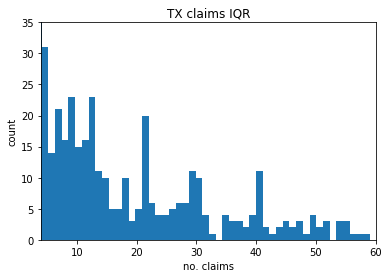

In [106]:
ax = texas_iqr['closed_loss'].plot(kind = 'hist', xlim = [4, 60], ylim = [0, 35],
                                   bins = 50,
                                  title = 'TX claims IQR')
ax.set(xlabel = 'no. claims', ylabel = 'count')

Ok, now what be even more interesting is focusing on the counties that have the most amount of claims.

We can look at the values at the higher percentiles the `describe` method and using the percentiles method.  Set percentiles of `.85, .90, .95` and `.99`. 

In [110]:
texas_df['closed_loss'].describe(percentiles = [.85, .90, .95, .99])

count      896.000000
mean       241.588170
std       1922.330777
min          0.000000
50%         10.500000
85%        141.500000
90%        292.500000
95%        718.250000
99%       2397.700000
max      45059.000000
Name: closed_loss, dtype: float64

Now notice that there's even a huge gap between data in our 99th percentile, and our county with the maximum number of claims.

Let's look at some of the counties with some of the highest number of claims.  To do so, use the `sort_by` method in pandas.

In [126]:
sorted_tx = texas_df.sort_values(by = 'closed_loss', ascending = False)

sorted_tx[['county', 'community', 'closed_loss']][:5]

# 	county	community	closed_loss
# 13635	HARRIS COUNTY	HOUSTON, CITY OF	45059.00
# 13632	HARRIS COUNTY	HARRIS COUNTY*	26988.00
# 13573	GALVESTON COUNTY	GALVESTON COUNTY*	14203.00
# 13574	GALVESTON COUNTY	GALVESTON, CITY OF	14098.00
# 13870	MONTGOMERY COUNTY	MONTGOMERY COUNTY*	6446.00

,county,community,closed_loss
13635,HARRIS COUNTY,"HOUSTON, CITY OF",45059.00
13632,HARRIS COUNTY,HARRIS COUNTY*,26988.00
13573,GALVESTON COUNTY,GALVESTON COUNTY*,14203.00
13574,GALVESTON COUNTY,"GALVESTON, CITY OF",14098.00
13870,MONTGOMERY COUNTY,MONTGOMERY COUNTY*,6446.00


> If you're like me, scientific notation can be pretty confusing.  We can get rid of it with the following.

In [119]:
pd.options.display.float_format = '{:.2f}'.format

In [142]:
sorted_tx_reduced = sorted_tx[['county', 'community', 'closed_loss']]
sorted_tx_reduced[:4]

,county,community,closed_loss
13635,HARRIS COUNTY,"HOUSTON, CITY OF",45059.00
13632,HARRIS COUNTY,HARRIS COUNTY*,26988.00
13573,GALVESTON COUNTY,GALVESTON COUNTY*,14203.00
13574,GALVESTON COUNTY,"GALVESTON, CITY OF",14098.00


Notice that we see both counties and cities for Harris and Galveston.  We also see similar claim numbers.  It could be that the county encompasses the city.  

> We probably should look into what those asterisks mean.

Let's keep going though.  Let's create a column which captures the percentage of the total closed losses for each county.

In [144]:
total_closed_loss = sorted_tx_reduced['closed_loss'].sum()

In [146]:
percent_closed_loss = sorted_tx_reduced['closed_loss']/total_closed_loss
percent_closed_loss[:5]

13635   0.21
13632   0.12
13573   0.07
13574   0.07
13870   0.03
Name: closed_loss, dtype: float64

Here's a quick check that we did this correctly.

In [147]:
percent_closed_loss.sum()
# 1.0

1.0

Now let's assign this column to our `sorted_tx_reduced` dataframe.

In [134]:
sorted_tx_reduced[:5]

,county,community,closed_loss,closed_loss_percent_total
13635,HARRIS COUNTY,"HOUSTON, CITY OF",45059.00,0.42
13632,HARRIS COUNTY,HARRIS COUNTY*,26988.00,0.25
13573,GALVESTON COUNTY,GALVESTON COUNTY*,14203.00,0.13
13574,GALVESTON COUNTY,"GALVESTON, CITY OF",14098.00,0.13
13870,MONTGOMERY COUNTY,MONTGOMERY COUNTY*,6446.00,0.06


In [139]:
import numpy as np
np.sum(sorted_tx_reduced['closed_loss_percent_total'][:5])

1.0

In [148]:
sorted_tx_percent_df = sorted_tx_reduced.assign(closed_loss_percent_total = percent_closed_loss)

In [159]:
sorted_tx_percent_df['closed_loss_percent_total'][:6].sum()
# 0.46358

0.5194097836581771

So we can see over fifty percent of the closed losses in texas are in just 6 of Texas's 896 counties.

In [158]:
sorted_tx_percent_df[:6]

,county,community,closed_loss,closed_loss_percent_total
13635,HARRIS COUNTY,"HOUSTON, CITY OF",45059.00,0.21
13632,HARRIS COUNTY,HARRIS COUNTY*,26988.00,0.12
13573,GALVESTON COUNTY,GALVESTON COUNTY*,14203.00,0.07
13574,GALVESTON COUNTY,"GALVESTON, CITY OF",14098.00,0.07
13870,MONTGOMERY COUNTY,MONTGOMERY COUNTY*,6446.00,0.03
13307,BRAZORIA COUNTY,BRAZORIA COUNTY *,5639.00,0.03


### Resources

[WP dashboard](https://wpinvestigative.github.io/fema_claims/)